In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
train = pd.read_csv("/Users/sergeiakhmadulin/My Drive/Fake news/train.csv", on_bad_lines='skip',sep=';')
val = pd.read_csv("/Users/sergeiakhmadulin/My Drive/Fake news/evaluation.csv", on_bad_lines='skip',sep=';')
test = pd.read_csv("/Users/sergeiakhmadulin/My Drive/Fake news/test.csv", on_bad_lines='skip',sep=';')

In [24]:
# Function to calculate the proportion of 1's and 0's in the target column
def calculate_proportions(df):
    prop_1 = df['label'].mean()  # proportion of 1's
    prop_0 = 1 - prop_1          # proportion of 0's
    return prop_0, prop_1

In [27]:
# Calculate proportions for each dataset
prop_0_train, prop_1_train = calculate_proportions(train)
prop_0_val, prop_1_val = calculate_proportions(val)
prop_0_test, prop_1_test = calculate_proportions(test)

# Create a DataFrame for plotting
proportions = pd.DataFrame({
    'Real': [prop_0_train, prop_0_val, prop_0_test],
    'Fake': [prop_1_train, prop_1_val, prop_1_test]
}, index=['Train', 'Validation', 'Test'])


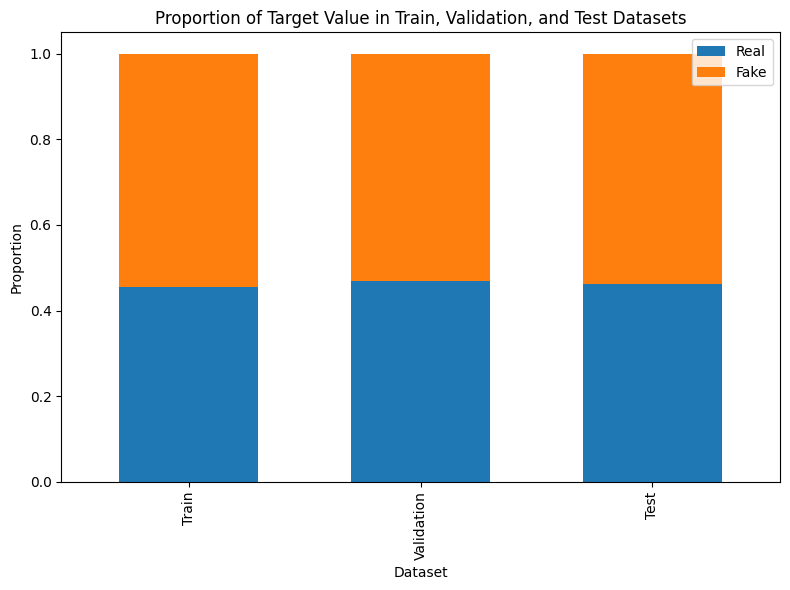

In [28]:
# Plot the bar chart
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the stacked bar chart
proportions.plot(kind='bar', stacked=True, ax=ax, width=0.6)

# Add labels and title
ax.set_xlabel('Dataset')
ax.set_ylabel('Proportion')
ax.set_title('Proportion of Target Value in Train, Validation, and Test Datasets')

# Set custom x-axis labels for each dataset
ax.set_xticklabels(['Train', 'Validation', 'Test'])

# Display the plot
plt.tight_layout()
plt.show()